## Анализ поведения пользователей в мобильном приложении

### Предобработка данных

In [1]:
# импорт библиотек
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# позволяет выводить данные из ячейки подряд без print() и display()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Снимаем ограничение на количество и ширину столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)

In [3]:
# чтение данных
try:
    mobile_dataset = pd.read_csv('/data/mobile_dataset.csv')
    mobile_source = pd.read_csv('/data/mobile_sources.csv')
except:
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
    mobile_source = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [4]:
# вывод информации
mobile_dataset.info()
mobile_dataset.head()
print()
mobile_source.info()
mobile_source.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [5]:
# изменим имена столбцов
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']
mobile_source.columns = ['user_id', 'source']

mobile_dataset.head(1)
mobile_source.head(1)

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other


In [6]:
# изменим тип данных в столбце 'event_time' на тип datetime
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [7]:
# отобразим диапазоны дат
mobile_dataset['event_time'].describe().loc[['min', 'max']]

min    2019-10-07 00:00:00.431357
max    2019-11-03 23:58:12.532487
Name: event_time, dtype: object

In [8]:
# выведем уникальные значения event_name
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

по условию задания значения 'contacts_show' и 'show_contacts' равнозначны

In [9]:
# поменяем значение show_contacts на contacts_show в параметре event_name
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

In [10]:
# проверим source на неявные дубликаты
mobile_source['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

имеем три типа источников: 'other', 'yandex', 'google'

In [11]:
# проверим данные на наличие пропусков в mobile_dataset
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [12]:
# проверим данные на наличие пропусков в mobile_source
mobile_source.isna().sum()

user_id    0
source     0
dtype: int64

In [13]:
# проверим mobile_dataset на дубликаты
print("Количество обнаруженных дубликатов:", mobile_dataset.duplicated().sum())

Количество обнаруженных дубликатов: 0


In [14]:
# проверим mobile_source на дубликаты
print("Количество обнаруженных дубликатов:", mobile_source.duplicated().sum())

Количество обнаруженных дубликатов: 0


In [15]:
# количество уникальных 'user_id' в mobile_dataset столько же сколько строк в mobile_source
print('Уникальных значений user_id в mobile_dataset: ', mobile_dataset['user_id'].nunique())

Уникальных значений user_id в mobile_dataset:  4293


In [16]:
# соединим таблицы методом merge()
mobile_df = mobile_dataset.merge(mobile_source, on='user_id')
mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


**Вывод**  
В результате предобработки данных мы:
- прочитали данные из двух csv-файлов;
- выяснили, что датафрейм mobile_dataset имеет три параметра: event_time, event_name, user_id и 74197 наблюдений;
- выяснили, что датафрейм mobile_source имеет два параметра: userId, source и 4293 наблюдения;
- переименовали названия столбцов в обоих датафреймах;
- преобразовали данные в колонке event_time из типа object в тип datetime;
- обнаружили, что временной диапазон данных от 2019-10-07 до 2019-11-03
- поменяли значения параметра event_name show_contacts на contacts_show;
- выявили, что пропусков и дубликатов в датафреймах не обнаружено;
- неявных дубликатов не обнаружено;
- уникальных значений user_id:  4293
- объединили датафреймы mobile_dataset и mobile_source в один.

### Исследовательский анализ данных

#### Выделение сессий

Согласно стандарту [OWASP(Open Web Application Security Project](https://cheatsheetseries.owasp.org/cheatsheets/Session_Management_Cheat_Sheet.html#:~:text=Both%20the%20idle,and%208%20hours). рекомендуется устанавливать тайм-аут между сессиями равным 2-5 мин для приложений требующих повышенной безопасности и 15-30 минут для обычных приложений. Т.к. наше мобильное приложение "Ненужные вещи" не требует высокого уровня безопасности, то выберем продолжительность бездействия пользователей в 15 мин. Однако, какой таймаут был выбран для данного приложения разумнее это выяснить у разработчиков.

In [17]:
# выделение сессий для каждого пользователя
mobile_df = mobile_df.sort_values(['user_id', 'event_time']).reset_index(drop=True)
sessions = (mobile_df.groupby('user_id')['event_time'].diff() > pd.Timedelta('15Min')).cumsum()
mobile_df['session_id'] = mobile_df.groupby(['user_id', sessions], sort=False).ngroup() + 1
mobile_df

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,11536
74193,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,11536
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,11537
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,11537


Всего у нас 11537 сессий

In [18]:
# рассчитаем количество уникальных сессий на каждого пользователя
sessions_per_user = mobile_df.groupby('user_id')['session_id'].nunique().to_frame().reset_index()
sessions_per_user.columns = ['user_id', 'sessions_count']
sessions_per_user.sort_values('sessions_count')

,user_id,sessions_count
2146,80a9887a-d45f-44a2-9473-1446f68b9c16,1
2040,7a8d8ffa-62a1-4c29-bb4c-98659c52f704,1
2041,7a9109a8-7b24-4cdc-a0c9-badb07548c59,1
2042,7a97a344-0a02-4916-918f-de1e72b22654,1
2044,7aadb909-92da-42ff-8a7d-e7caae129338,1
...,...,...
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,46
3162,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,55
401,1580911b-65db-4f1a-be7e-1ca39becac30,58
3397,cb36854f-570a-41f4-baa8-36680b396370,79


In [19]:
# статистика распределения сессий
sessions_per_user['sessions_count'].describe().to_frame()

,sessions_count
count,4293.000000
mean,2.687398
std,4.173946
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,116.000000


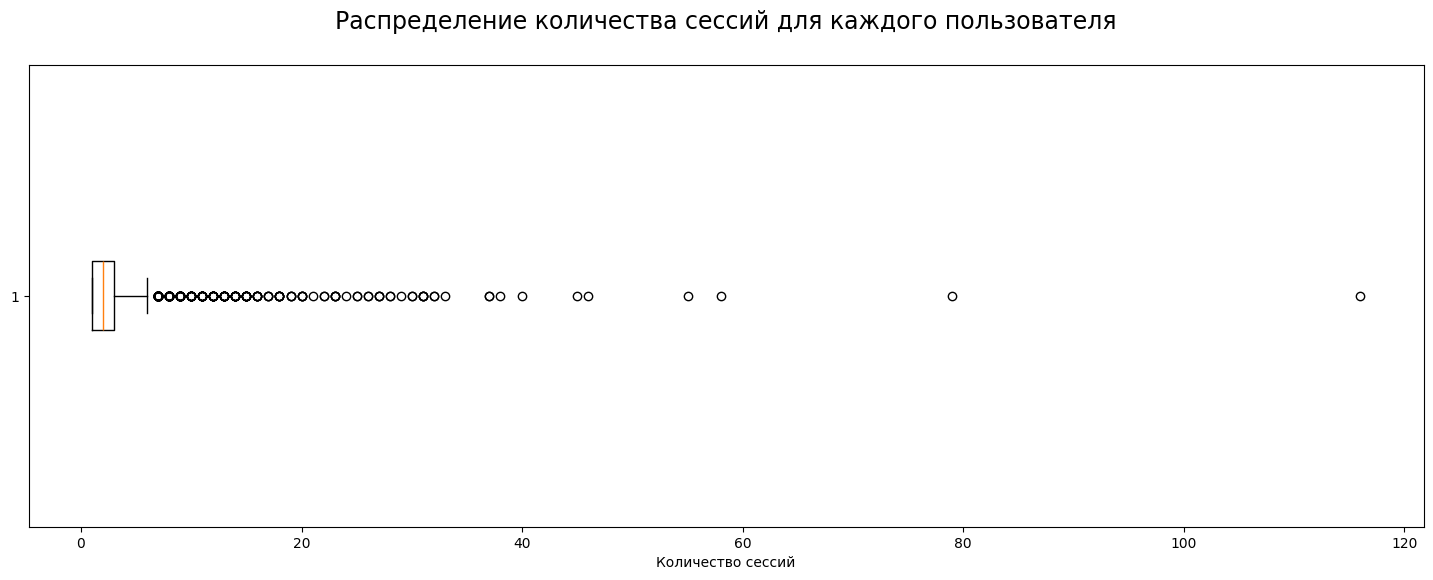

In [20]:
# построим диаграмму boxplot для распределения сессий для каждого пользователя
plt.figure(figsize=(18, 6))
plt.boxplot(sessions_per_user['sessions_count'], vert=False)
plt.xlabel('Количество сессий')
plt.title('Распределение количества сессий для каждого пользователя' + "\n", fontsize=17)
plt.show();

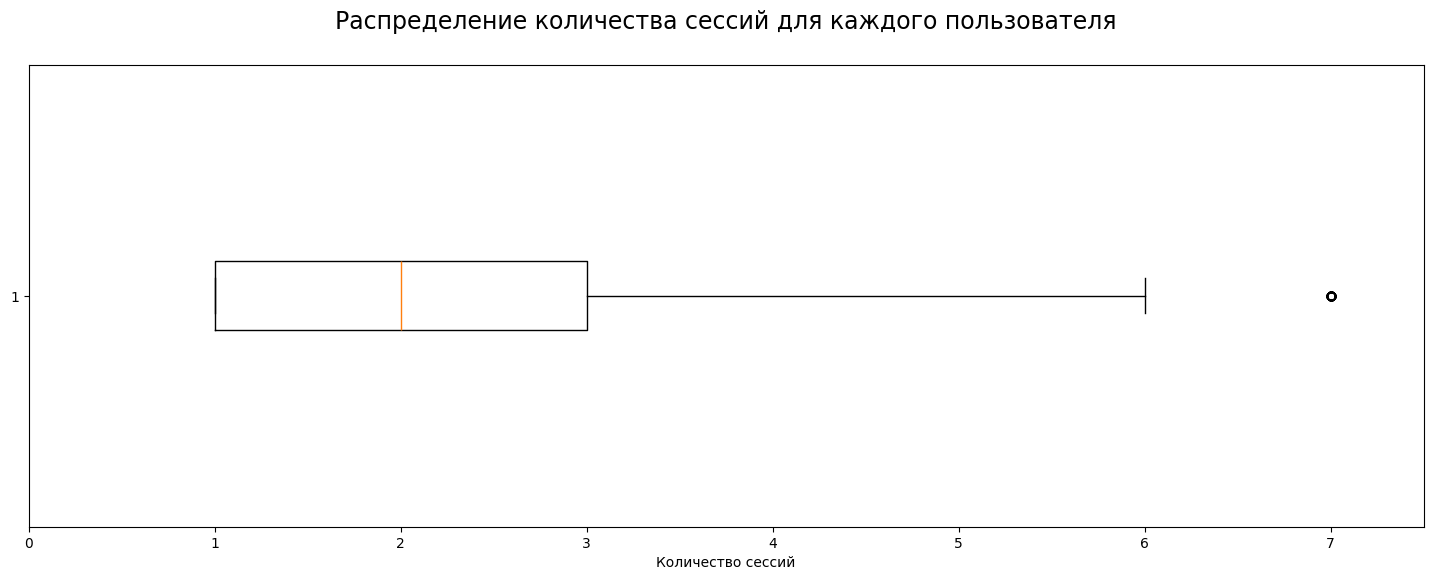

In [21]:
# увеличим масштаб диаграммы
plt.figure(figsize=(18, 6))
plt.boxplot(sessions_per_user['sessions_count'], vert=False)
plt.xlabel('Количество сессий')
plt.title('Распределение количества сессий для каждого пользователя' + "\n", fontsize=17)
plt.xlim(0, 7.5)
plt.show();

Минимальное количество сессий на одного пользователя равно 1, максимальное - 116 сессий на пользователя. По медиане, на одного пользователя приходится 2 сессии.

##### Длительность сессий

In [22]:
# рассчитаем длительность сессий
sessions_duration = mobile_df.groupby(['session_id', 'user_id']).agg(
    time_span=('event_time', lambda x: (x.max() - x.min())/np.timedelta64(60, 's'))
).reset_index()
sessions_duration.head()

,session_id,user_id,time_span
0,1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,9.928788
1,2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,8.456433
2,3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,14.987868
3,4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,12.636196
4,5,00157779-810c-4498-9e05-a1e9e3cedf93,25.346455


In [23]:
# статистика длительности сессий
sessions_duration['time_span'].describe().to_frame()

,time_span
count,11537.000000
mean,9.440873
std,14.186460
min,0.000000
25%,0.082008
50%,4.323255
75%,13.054267
max,233.648530


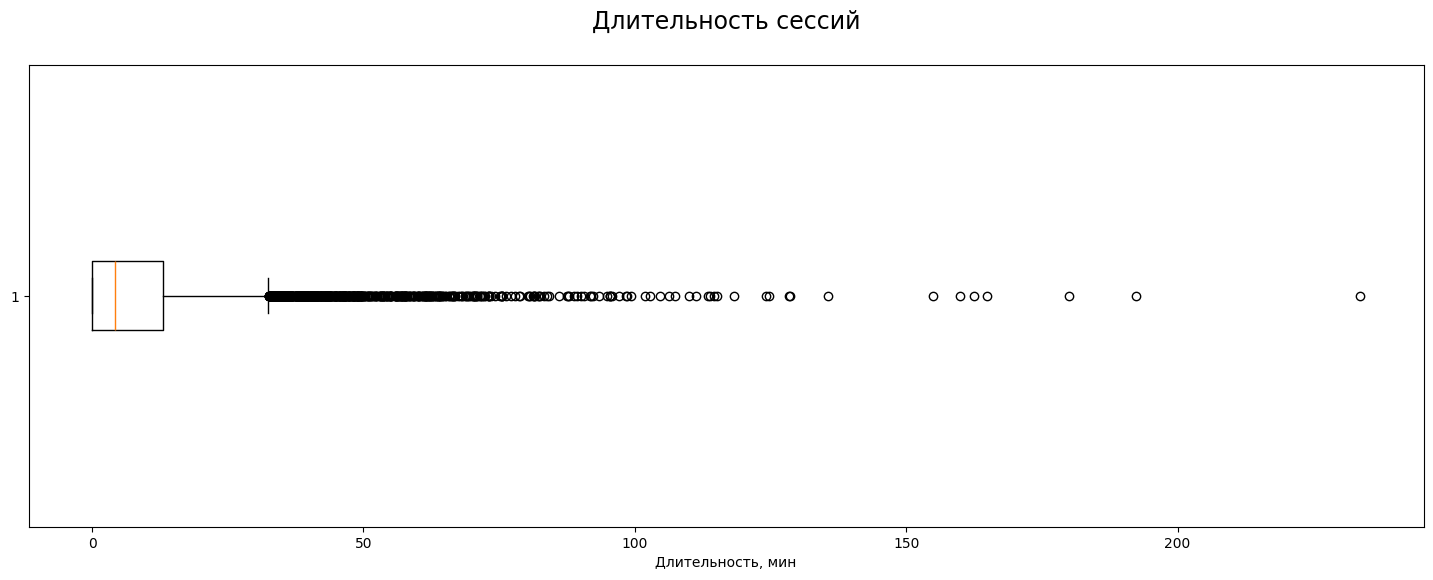

In [24]:
# построим диаграмму размаха длительности сессий
plt.figure(figsize=(18, 6))
plt.boxplot(sessions_duration['time_span'], vert=False)
plt.xlabel('Длительность, мин')
plt.title('Длительность сессий' + "\n", fontsize=17)
plt.show();

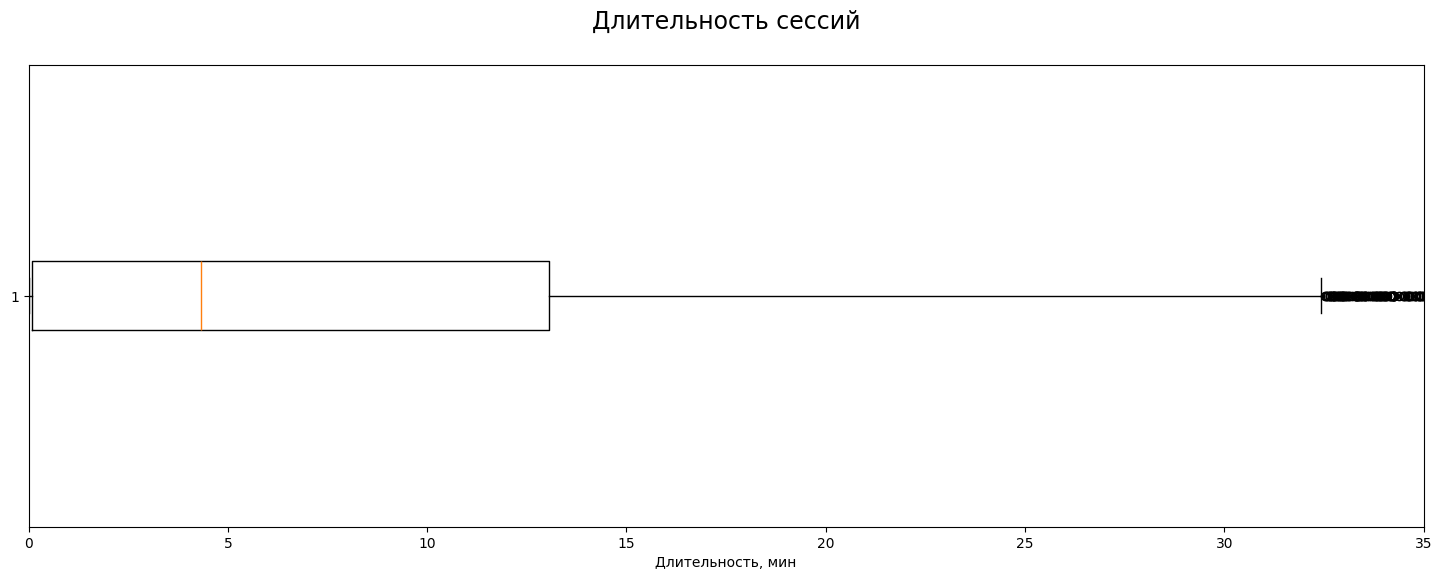

In [25]:
# увеличим масштаб диаграммы
plt.figure(figsize=(18, 6))
plt.boxplot(sessions_duration['time_span'], vert=False)
plt.xlabel('Длительность, мин')
plt.title('Длительность сессий' + "\n", fontsize=17)
plt.xlim(0, 35)
plt.show();

Длительность сессий варьируется от 0 до 233 минут. Медианное значение длительности сессии составляет 4 минуты, среднее значение - 9 минут.

#### Частотность событий

##### Рассмотрим распределение событий по пользователям

In [26]:
# распределение событий по пользователям
events_per_user = mobile_df.groupby('user_id')[['event_name']].count()\
                    .rename(columns={'event_name':'count_events'}).reset_index()
events_per_user

,user_id,count_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7
4290,ffcf50d9-293c-4254-8243-4890b030b238,2
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13


In [27]:
# статистика распределения событий по пользователям
events_per_user['count_events'].describe().to_frame()

,count_events
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


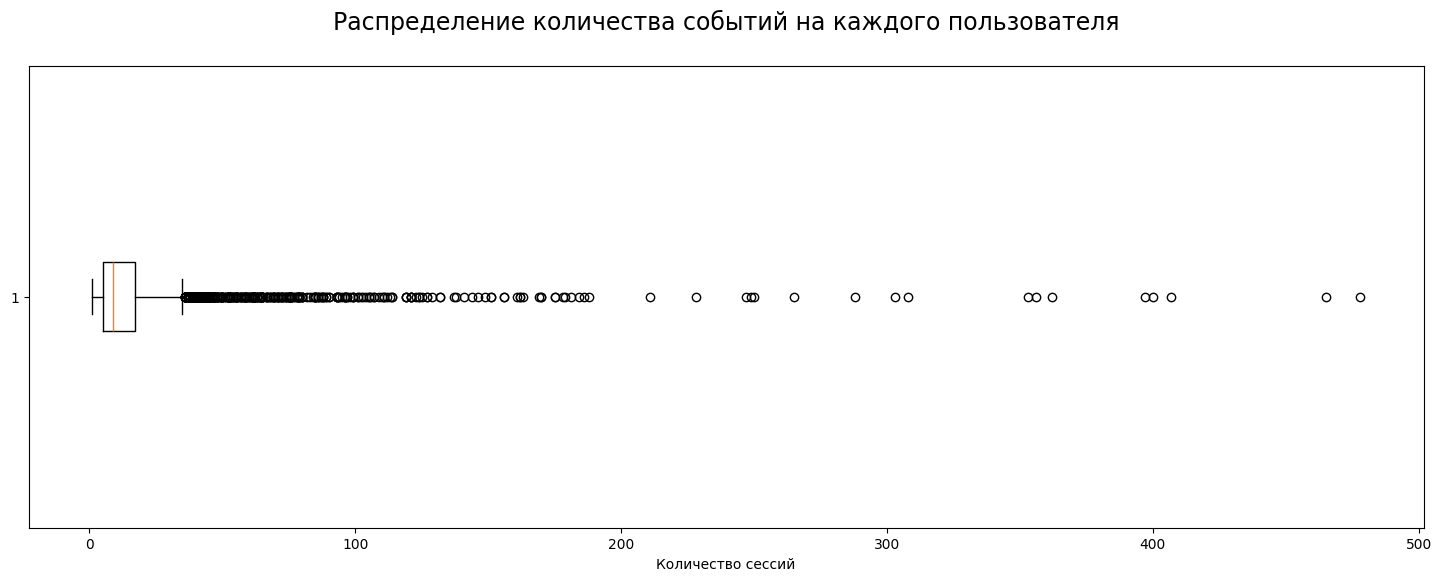

In [28]:
# построим диаграмму boxplot для распределения событий на каждого пользователя
plt.figure(figsize=(18, 6))
plt.boxplot(events_per_user['count_events'], vert=False)
plt.xlabel('Количество сессий')
plt.title('Распределение количества событий на каждого пользователя' + "\n", fontsize=17)
plt.show();

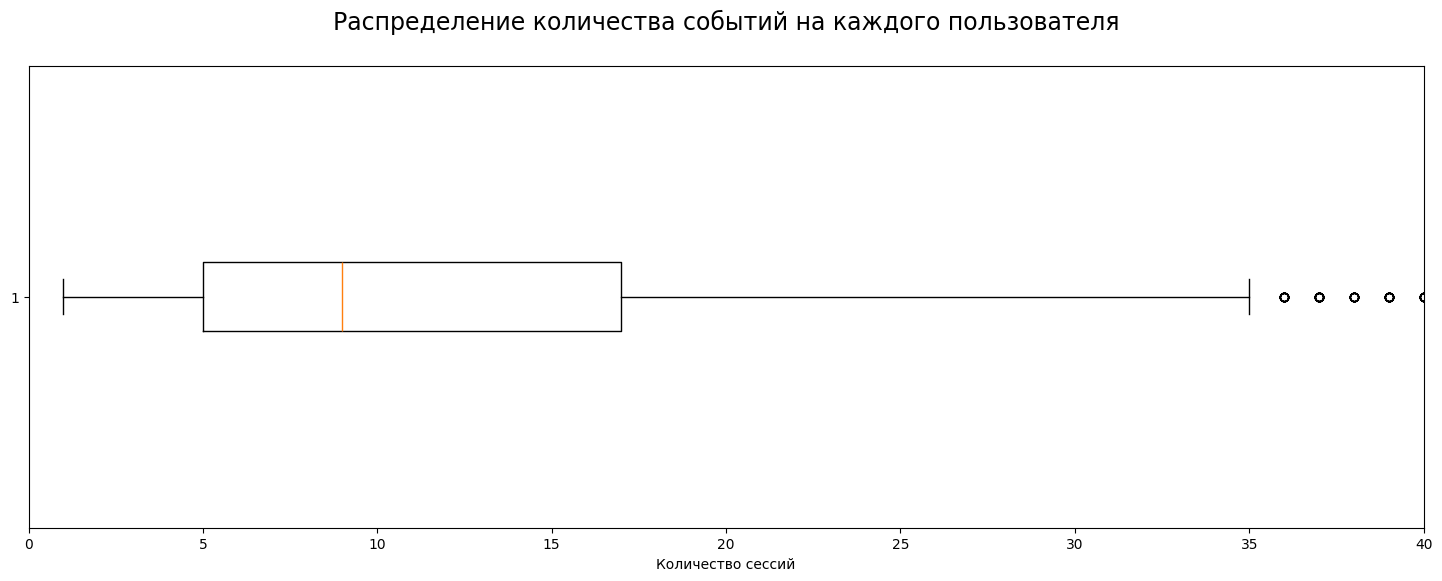

In [29]:
# увеличим масштаб диаграммы
plt.figure(figsize=(18, 6))
plt.boxplot(events_per_user['count_events'], vert=False)
plt.xlabel('Количество сессий')
plt.title('Распределение количества событий на каждого пользователя' + "\n", fontsize=17)
plt.xlim(0, 40)
plt.show();

Медиана событий на одного пользователя составляет 9 событий.  Минимальное количество - 1, максимальное - 478 событий на пользователя.

##### Рассмотрим распределение событий по типу

In [30]:
# распределение событий по типу
events_distr = mobile_df.groupby('event_name').size().reset_index(name = 'count').sort_values('count', ascending =False)
events_distr = events_distr.reset_index(drop=True)
events_distr

,event_name,count
0,tips_show,40055
1,photos_show,10012
2,advert_open,6164
3,contacts_show,4529
4,map,3881
5,search_1,3506
6,favorites_add,1417
7,search_5,1049
8,tips_click,814
9,search_4,701


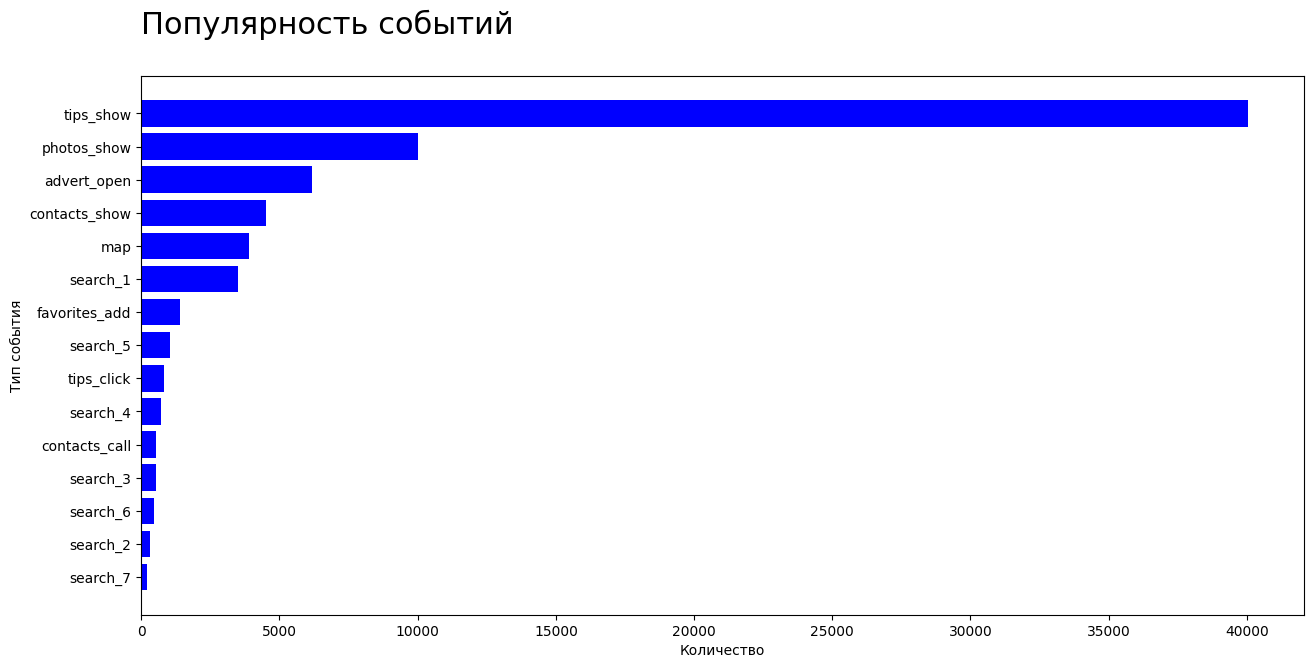

In [31]:
# построим график распределений

fig, ax = plt.subplots(figsize=(15, 7))
events_distr_sorted = events_distr.sort_values('count')

ax.barh(events_distr_sorted['event_name'], events_distr_sorted['count'], color='blue')

ax.set_title('Популярность событий' + "\n", fontsize=22, loc='left')
ax.set_xlabel('Количество')
ax.set_ylabel('Тип события')

plt.show();

Самым популярным событием у пользователей являются 'tips_show', т.е. просмотр рекомендованных объявлений, вторым по популярности действием является просмотр фотографий, далее следуют 'advert_open', 'contacts_show', 'map'. Замыкают рейтинг события, связанные с поисковыми запросами. Т.к. действие tips_show отображается автоматически и не зависит от наличия предыдущего действия пользоватлей мы не будем включать его в наши некоторые расчёты.

**Вывод**  

**Безопасность и таймаут сессий:**  
Поскольку приложение не требует высокого уровня безопасности, выбор продолжительности бездействия пользователей в 15 минут разумен.  
Однако рекомендуется уточнить у разработчиков, какой таймаут был выбран для данного приложения.  

**Сессии пользователей:**  
Минимальное количество сессий на одного пользователя составляет 1, а максимальное - 116.  
По медиане на одного пользователя приходится 2 сессии.  
Длительность сессий варьируется от 0 до 233 минут. Медианное значение длительности сессии составляет 4 минуты, а среднее - 9 минут.  

**События в приложении:**  
Медиана событий на одного пользователя составляет 9.  
Самым популярным событием у пользователей является ‘tips_show’ (просмотр рекомендованных объявлений).  
Вторым по популярности действием является просмотр фотографий.  
Затем следуют ‘advert_open’, ‘contacts_show’ и ‘map’.  
События, связанные с поисковыми запросами, замыкают рейтинг.  

В целом, приложение “Ненужные вещи” имеет потенциал привлечь пользователей, а оптимизация сессий и событий может помочь улучшить пользовательский опыт.

### Выявление сценариев пользователей

Избавимся от повторяющихся событий в рамках сессии

In [32]:
# унифицируем сценарии и объединим значения serch_1 ... search_7 в одно значение
script = mobile_df[mobile_df['event_name']!='tips_show'].copy()
script["event_name"] = script["event_name"].str.replace(r'search_\d+', 'search', regex=True)
script = script.drop_duplicates(['event_name', 'user_id'],keep='first')
script = script.rename(columns={'source': 'browser'})
script.head(10)

,event_time,event_name,user_id,browser,session_id
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2
35,2019-10-19 21:34:33.849769,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
38,2019-10-19 21:40:38.990477,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
46,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6
50,2019-10-20 19:17:18.659799,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6
51,2019-10-20 19:17:24.887762,contacts_call,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6
64,2019-10-24 10:52:18.644065,advert_open,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,8
106,2019-11-01 13:54:35.385028,photos_show,00463033-5717-4bf1-91b4-09183923b9df,yandex,14
116,2019-10-18 22:14:05.555052,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,15
118,2019-10-18 22:17:40.719687,map,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,15


**Для визуального анализа сценариев построим диаграмму Санкея**

In [33]:
# функция определения source-target

def add_features(df):   
    """Функция генерации новых столбцов для исходной таблицы
    Args: df (pd.DataFrame): исходная таблица.
    Returns: pd.DataFrame: таблица с новыми признаками.
    """
    # cортируем по session_id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
table = add_features(script)
table.head()

,event_time,user_id,browser,session_id,step,source,target
9,2019-10-09 18:33:55.577963,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,1,map,NaN
35,2019-10-19 21:34:33.849769,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5,1,search,photos_show
38,2019-10-19 21:40:38.990477,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5,2,photos_show,NaN
46,2019-10-20 19:03:02.030004,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6,1,favorites_add,contacts_show
50,2019-10-20 19:17:18.659799,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6,2,contacts_show,contacts_call


In [34]:
# ограничение количества шагов на диаграмме
df_comp = table[table['step'] <= 4].copy().reset_index(drop=True)

In [35]:
# функция создания словаря с индексами source

def get_source_index(df):
    
    """Функция генерации индексов source
    Args: df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns: dict: словарь с индексами, именами и соответствиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [36]:
# Функция случайной генерации цветов

def generate_random_color():
    
    """Случайная генерация цветов rgba
    Returns: str: Строка сгенерированных параметров цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [37]:
# Создание словаря с соответствиями source: color

def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:mode (str): сгенерировать случайные цвета, если 'random', a если 'custom' - 
                    использовать заранее подготовленные
    Returns: dict: словарь c цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [38]:
# Функция расчета количества уникальных пользователей в процентах

def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns: list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [39]:
# Функция создания словаря с данными для отрисовки диаграммы

def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=1):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns: dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]


In [40]:
# Функция создание объекта диаграммы

def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Санкей 
    
    Args: data_dict (dict): словарь со списками данных для построения.   
    
    Returns: plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Диаграмма Sankey для пользовательских сценариев ", font_size=15, width=980, height=800)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

In [41]:
# Создаём диаграмму
senkey_diagram.show()

In [42]:
# открытие диаграммы в браузере
# senkey_diagram.write_html('demo_senkey.html', auto_open=True)

**Вывод**  

Диаграмма Санкея даёт наглядное представления о распределение основных сценариев поведения пользователей.  
Нас интересуют сценарии, имеющие 2 и более шагов до целевого события (ЦС) -  contacts_show.  
 
Как показывает диаграмма мы можем выбрать следующие сценарии для анализа:

Сценарий 1. **search -> photos_show -> contacts_show** (поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона)  

Сценарий 2. **map -> advert_open -> contacts_show** (открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона)  

Сценарий 3. **map -> search -> contacts_show** (открыл карту объявлений => поиск => посмотрел номер телефона)  

Сценарий 4. **search -> map -> contacts_show** ( поиск => открыл карту объявлений => посмотрел номер телефона)  

### Расчёт конверсий и  воронок сценариев

В расчетах мы используем параметр `step_interval`, который обозначает временной интервал между окончанием первого и второго события. Мы уже рассчитали, что медианное время длительности сессий 4.3 минуты, поэтому для расчёта возьмём интервал равный 5 минутам.

In [43]:
# Функция расчёта количества пользователей на этапах сценария в зависимости от продолжительности совершения событий

def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=pd.Timedelta(5, "m")):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots

    :param df: (pd.DataFrame)
                    events df having 'distinct_id' and 'name' columns

    :param steps: (list)
                    list containing funnel steps as strings

    :param from_date: (str)
                    date with format "yyyy-mm-dd"

    :param to_date: (str)
                    date with format "yyyy-mm-dd"

    :param step_interval: (pd.Timedelta)
                    for more info:
                    https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html

    :return: (pd.DataFrame)
                df with 'step', 'val', 'pct', 'val-1' columns
    """
    assert isinstance(steps, list), '"steps" should be a list of strings'

    if step_interval != 0:
        assert isinstance(step_interval, pd.Timedelta), \
            '"step_interval" should be a valid pd.Timedelta object. For more info visit:' \
            'https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html'

    # filter df for only events in the steps list
    df = df[['distinct_id', 'name', 'time']]
    df = df[df['name'].isin(steps)]

    values = []
    # create a dict to hold the filtered dataframe of each step
    dfs = {}
    # for each step, create a df and filter only for that step
    for i, step in enumerate(steps):
        if i == 0:

            # filter for users that did the 1st event and find the minimum time
            dfs[step] = df[df['name'] == step] \
                .sort_values(['distinct_id', 'time'], ascending=True) \
                .drop_duplicates(subset=['distinct_id', 'name'], keep='first')

            # filter df of 1st step according to dates
            # this will allow the 1st step to have started during the defined period
            # but subsequent steps are allowed to occur at a later date so that the funnel
            # is not penalised unfairly
            if from_date:
                dfs[step] = dfs[step][(dfs[step]['time'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['time'] <= to_date)]

        else:
            # filter for specific event
            dfs[step] = df[df['name'] == step]

            # left join with previous step
            # this ensures only rows for which the distinct_ids appear in the previous step
            merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='distinct_id', how='left')

            # keep only events that happened after previous step and sort by time
            merged = merged[merged['time_y'] >=
                            (merged['time_x'] + step_interval)].sort_values('time_y', ascending=True)

            # take the minimum time of the valid ones for each user
            merged = merged.drop_duplicates(subset=['distinct_id', 'name_x', 'name_y'], keep='first')

            # keep only the necessary columns and rename them to match the original structure
            merged = merged[['distinct_id', 'name_y', 'time_y']].rename({'name_y': 'name',
                                                                         'time_y': 'time'}, axis=1)

            # include the df in the df dictionary so that it can be joined to the next step's df
            dfs[step] = merged

        # append number of users to the "values" list
        values.append(len(dfs[step]))

    # create dataframe
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    return funnel_df

In [44]:
# Функция построения воронки сценария

def funnel_diagram(step_0, step_1, step_2, title):
    step_name = [step_0, step_1, step_2]

    df = mobile_df[['user_id', 'event_name', 'event_time']].rename(columns={'user_id': 'distinct_id', 'event_name': 'name', 'event_time': 'time'})
    df["name"] = df["name"].str.replace(r'search_\d+', 'search', regex=True)

    dfx = create_funnel_df(df, step_name)

    fig = go.Figure(go.Funnel(y = step_name,
                           x = [dfx.loc[0,'val'], dfx.loc[1,'val'], dfx.loc[2,'val']],
                           textposition=['inside', 'outside','outside'],
                           textfont = {'size': 15}, 
                           textinfo = 'value + percent previous + percent initial'
                           ))

    fig.update_layout(title_text=f'Сценарий: {title}',
                  height=500, width= 950, margin=dict(l=10, r=10, b=10))
    fig.show()

    print(f'Конверсия пользователей по сценарию "{title}" составляет {dfx.loc[2,"val"]/dfx.loc[0,"val"]:.2%}')


#### Сценарий 1. Поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона

In [45]:
# построим воронку сценария 1

title = "поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона"
funnel_diagram('search', 'photos_show', 'contacts_show', title)

Конверсия пользователей по сценарию "поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона" составляет 5.04%


#### Сценарий 2. Открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона

In [46]:
# построим воронку сценария 2.

title = "открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона"
funnel_diagram('map','advert_open','contacts_show', title)

Конверсия пользователей по сценарию "открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона" составляет 3.43%


#### Сценарий 3. Открыл карту объявлений => поиск => посмотрел номер телефона

In [47]:
# построим воронку сценария 3.

title = "открыл карту объявлений => поиск => посмотрел номер телефона"
funnel_diagram('map','search','contacts_show', title)

Конверсия пользователей по сценарию "открыл карту объявлений => поиск => посмотрел номер телефона" составляет 2.75%


#### Сценарий 4. Поиск => открыл карту объявлений => посмотрел номер телефона телефона

In [48]:
# построим воронку сценария 4.

title = "поиск => открыл карту объявлений => посмотрел номер телефона"
funnel_diagram('search', 'map', 'contacts_show', title)

Конверсия пользователей по сценарию "поиск => открыл карту объявлений => посмотрел номер телефона" составляет 2.52%


**Вывод**   

В результате проведённого исследования мы пришли к следующим результатам:  
- Конверсия пользователей по сценарию **"поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона"** составляет `5.04%`  
- Конверсия пользователей по сценарию **"открыл карту объявлений => поиск => посмотрел номер телефона"** составляет `2.75%`
- Конверсия пользователей по сценарию **"открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона"** составляет `3.43%`    
- Конверсия пользователей по сценарию **"поиск => открыл карту объявлений => посмотрел номер телефона"** составляет `2.52%`  


Конверсия пользователей в мобильном приложении варьируется в зависимости от сценария взаимодействия. Наибольшая конверсия (5.04%) наблюдается при использовании сценария "поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона", в то время как наименьшая конверсия (2.52%) достигается при сценарии "поиск по сайту => открыл карту объявлений => посмотрел номер телефона". Для увеличения конверсии важно оптимизировать пользовательский опыт, сделав процесс поиска и просмотра информации более интуитивным и удобным. Рекомендуется также провести дополнительные исследования для выявления потенциальных улучшений в интерфейсе приложения и механизмах стимулирования пользователей к завершению целевых действий.



### Расчёт частоты событий в разрезе двух групп пользователей

 Оценим, какие действия чаще совершают пользователи из двух групп:  
- группа пользователей, которые смотрели контакты - contacts_show  
- группа пользователей, которые не смотрели контакты - contacts_show  

In [49]:
# группа пользователей, которые смотрели контакты
df_group = script.copy()
df_group["event_name"] = df_group["event_name"].str.replace(r'search_\d+', 'search', regex=True)
df_group_unique = df_group.query('event_name == "contacts_show"')['user_id'].unique()
contacts_show_group = df_group[df_group['user_id'].isin(df_group_unique)].groupby('event_name')\
                                                            .size().reset_index(name='count_of_show')
contacts_show_group['pct_of_show'] = ((contacts_show_group['count_of_show'] / contacts_show_group['count_of_show']\
                                                           .sum() * 100)).round(2)

# группа пользователей, которые не смотрели контакты
no_contacts_show_group = df_group[~df_group['user_id'].isin(df_group_unique)].groupby('event_name').\
                                                            size().reset_index(name='count_of_notshow')
no_contacts_show_group['pct_of_notshow'] = ((no_contacts_show_group['count_of_notshow'] / 
                                             no_contacts_show_group['count_of_notshow'].sum() * 100)).round(2)

# объединение групп
common_table = contacts_show_group.merge(no_contacts_show_group, on = 'event_name', how='left')
common_table = common_table.drop(columns=['count_of_show', 'count_of_notshow'])
common_table = common_table.sort_values('pct_of_notshow', ascending=False)
common_table

,event_name,pct_of_show,pct_of_notshow
6,search,14.65,30.24
4,map,11.23,27.38
5,photos_show,13.18,17.74
0,advert_open,5.36,14.38
7,tips_click,3.89,5.21
3,favorites_add,5.29,5.04
1,contacts_call,8.28,NaN
2,contacts_show,38.13,NaN


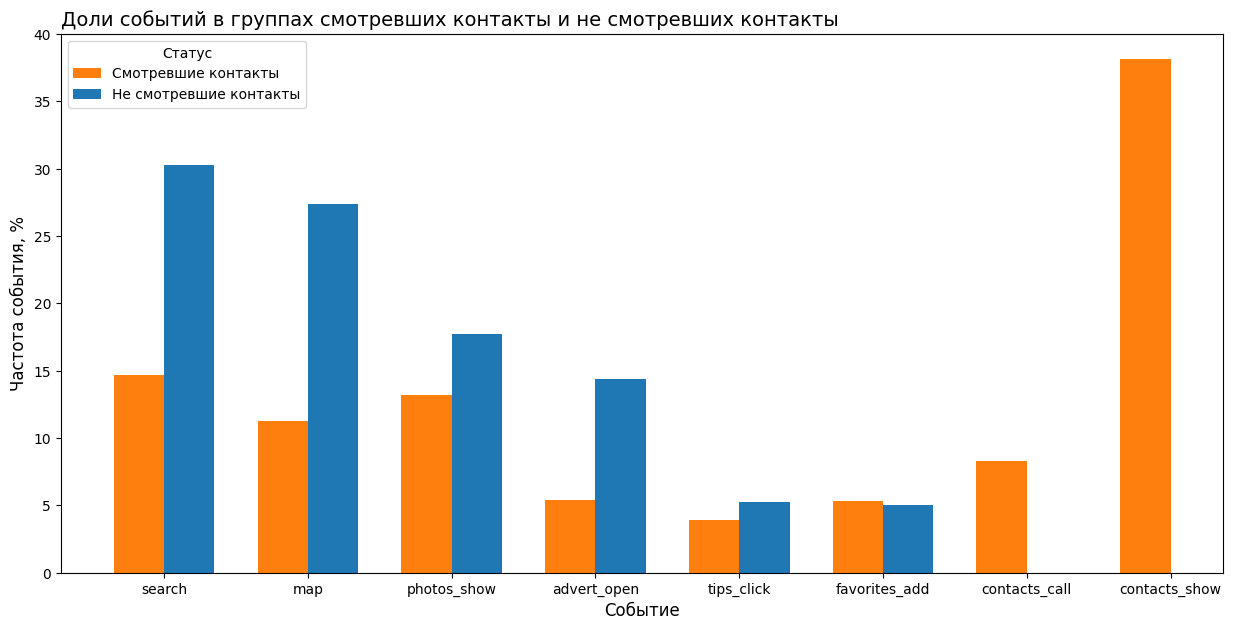

In [50]:
event_names = common_table['event_name']
pct_of_show = common_table['pct_of_show']
pct_of_notshow = common_table['pct_of_notshow']

fig, ax = plt.subplots(figsize=(15, 7))
bar_width = 0.35

index = np.arange(len(event_names))

bar1 = ax.bar(index, pct_of_show, bar_width, color='#ff7f0e', label='Смотревшие контакты')
bar2 = ax.bar(index + bar_width, pct_of_notshow, bar_width, color='#1f77b4', label='Не смотревшие контакты')

ax.set_xlabel('Событие', fontsize=12)
ax.set_ylabel('Частота события, %', fontsize=12)
ax.set_title('Доли событий в группах смотревших контакты и не смотревших контакты', fontsize=14, loc='left')

ax.legend(title='Статус')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(event_names)

plt.show();

**Вывод:**  

Из анализа представленной информации можно сделать вывод, что обе группы пользователей имеют схожие популярные действия. Можно отметить, что у группы просмотревшей контакты на втором месте по популярности после события search следует событие photos_show, в то время как у второй группы на втором месте событие map, а photos_show - на третьем. Также видно, что на последнем месте первой группы стоит событие tips_click, у второй группы, не смотревшей контакты - favorites_add.

### Проверка гипотез

In [51]:
# Формируем данные 

conversion_model = mobile_df.copy()
conversion_model["event_name"] = conversion_model["event_name"].str.replace(r'search_\d+', 'search', regex=True)
conversion_model = conversion_model.drop_duplicates(['event_name', 'user_id'],keep='first')
conversion_model = conversion_model.rename(columns={'source': 'browser'})
conversion_model.head()

,event_time,event_name,user_id,browser,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2
35,2019-10-19 21:34:33.849769,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
38,2019-10-19 21:40:38.990477,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
46,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6


#### Гипотеза 1.
Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show.   
Проверим гипотезу: конверсия в просмотры контактов(ЦС) различается у этих двух групп.  

In [52]:
# Рассчитаем количество пользователей совершивших "tips_show" + "tips_click"
tips_clicks_show = (conversion_model.query('event_name in ["tips_show", "tips_click"]')
                    .groupby('user_id').size().reset_index(name='count')
                    .loc[lambda x: x['count'] != 1]['user_id'])
print(f'Количество пользователей совершивших "tips_show" + "tips_click": {len(tips_clicks_show)}')

# Рассчитаем количество пользователей совершивших "tips_show" + "tips_click" и достигших ЦС "contacts_show"
tips_clicks_contacts_show = conversion_model.query('user_id in @tips_clicks_show and event_name == "contacts_show"')
print(f'Количество пользователей совершивших "tips_show" + "tips_click" и достигших ЦС "contacts_show: \
      {len(tips_clicks_contacts_show)}')

# Рассчитаем конверсию в ЦС
print(f'Коэффициент конверсии "tips_show" => "contacts_show": \
      {round((len(tips_clicks_contacts_show)/len(tips_clicks_show)),3)}')

Количество пользователей совершивших "tips_show" + "tips_click": 297
Количество пользователей совершивших "tips_show" + "tips_click" и достигших ЦС "contacts_show:       91
Коэффициент конверсии "tips_show" => "contacts_show":       0.306


In [53]:
# Рассчитаем количество пользователей совершивших "tips_show"
tips_show = conversion_model.query('event_name == "tips_show" and user_id not in @tips_clicks_show')['user_id']
print(f'Количество пользователей совершивших "tips_show": {len(tips_show)}')

# Рассчитаем количество пользователей совершивших "tips_show" и достигших ЦС "contacts_show"
tips_contacts_show = conversion_model.query('user_id in @tips_show and event_name == "contacts_show"')
print(f'Количество пользователей совершивших "tips_show" и достигших ЦС "contacts_show: {len(tips_contacts_show)}')

# Рассчитаем конверсию в ЦС
print(f'Коэффициент конверсии "tips_show" => "contacts_show": {round((len(tips_contacts_show)/len(tips_show)),3)}')

Количество пользователей совершивших "tips_show": 2504
Количество пользователей совершивших "tips_show" и достигших ЦС "contacts_show: 425
Коэффициент конверсии "tips_show" => "contacts_show": 0.17


Важно отметить, что конверсия первой группы, где у пользователей в качестве дополнительного шага было действие "tips_clicks" выше, чем второй группы.

Сформулируем нулевую(Н0) и альтернативную(H1) гипотезы.  
**H0**: "Конверсии в просмотры контактов у двух групп не различаются"  
**H1**: "Конверсии в просмотры контактов у двух групп различаются"  
Уровень статистической значимости alpha примем равным 0.05

In [54]:
# Проводим статистический тест
alpha = 0.05
count = np.array([len(tips_clicks_contacts_show), len(tips_contacts_show)])
nobs = np.array([len(tips_clicks_show), len(tips_show)])

stat_value, p_value = proportions_ztest(count, nobs)


print(f'Значение p_value: {p_value}')
if p_value < alpha:
    print(f'Отвергаем нулевую гипотезу: конверсия в ЦС у двух групп различаются!')
else:
    print(f'Принимаем нулевую гипотезу: конверсия в ЦС у двух групп не различаются!')

Значение p_value: 9.218316568768822e-09
Отвергаем нулевую гипотезу: конверсия в ЦС у двух групп различаются!


**Вывод**  
Гипотезу о том, что конверсия в просмотры контактов различается у двух групп опровергнуть не удалось. Группа "tips_show + tips_click" и группа "tips_show" имеют разные конверсии в ЦС.

#### Гипотеза 2.
Одни пользователи совершают действия tip_show, tips_click , другие — search, advert_open.   
Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп. 

In [55]:
print(f'Количество пользователей совершивших "tips_show" + "tips_click": {len(tips_clicks_show)}')
print(f'Количество пользователей совершивших "tips_show" + "tips_click" и достигших ЦС "contacts_show: \
    {len(tips_clicks_contacts_show)}')
print(f'Коэффициент конверсии "tips_show" => "contacts_show": \
    {round((len(tips_clicks_contacts_show)/len(tips_clicks_show)),3)}')

Количество пользователей совершивших "tips_show" + "tips_click": 297
Количество пользователей совершивших "tips_show" + "tips_click" и достигших ЦС "contacts_show:     91
Коэффициент конверсии "tips_show" => "contacts_show":     0.306


In [56]:
# Рассчитаем количество пользователей совершивших "search" и "advert_open"
map_df = (conversion_model.query('event_name == ["search", "advert_open"] and user_id not in @tips_clicks_show')
                    .groupby('user_id').size().reset_index(name='count')
                    .loc[lambda x: x['count'] != 1]['user_id'])
print(f'Количество пользователей совершивших "search" и "advert_open": {len(map_df)}')

# Рассчитаем количество пользователей совершивших "search" + "advert_open" и достигших ЦС "contacts_show"
map_advert_open_df = conversion_model.query('user_id in @map_df and event_name == "contacts_show"')
print(f'Количество пользователей совершивших "search" и "advert_open" и достигших ЦС "contacts_show: \
    {len(map_advert_open_df)}')

# Рассчитаем конверсию в ЦС
print(f'Коэффициент конверсии "search" => "contacts_show": {round((len(map_advert_open_df)/len(map_df)),3)}')

Количество пользователей совершивших "search" и "advert_open": 307
Количество пользователей совершивших "search" и "advert_open" и достигших ЦС "contacts_show:     68
Коэффициент конверсии "search" => "contacts_show": 0.221


Конверсия в группе, где пользователи пришли к ЦС через 'search' и 'advert_open' меньше, чем в группе, в которой пользователи пришили к ЦС через 'tips_show' и 'tips_click'

Сформулируем нулевую(Н0) и альтернативную(H1) гипотезы.  
**H0**: "Конверсии в просмотры контактов у двух групп не различаются"  
**H1**: "Конверсии в просмотры контактов у двух групп различаются"  
Уровень статистической значимости alpha примем равным 0.05

In [57]:
# Проводим статистический тест
alpha = 0.05
count = np.array([len(tips_clicks_contacts_show), len(map_advert_open_df)])
nobs = np.array([len(tips_clicks_show), len(map_df)])

stat_value, p_value = proportions_ztest(count, nobs)


print(f'Значение p_value: {p_value}')
if p_value < alpha:
    print(f'Отвергаем нулевую гипотезу: конверсия в ЦС у двух групп различаются!')
else:
    print(f'Принимаем нулевую гипотезу: конверсия в ЦС у двух групп не различаются!')

Значение p_value: 0.017856123537999282
Отвергаем нулевую гипотезу: конверсия в ЦС у двух групп различаются!


**Вывод**  
Гипотезу о том, что конверсия в просмотры контактов различается у двух групп опровергнуть не удалось. Группа "tips_show + tips_click" и группа "search + advert_open" имеют разные конверсии в ЦС.

### Общий итог

**Результаты предобработки данных:**  

---

1. `Чтение данных:`  
   - Данные были извлечены из двух csv-файлов.
2. `Датафрейм mobile_dataset:`
   - Содержит три параметра: event_time, event_name, user_id.
   - Объем данных составляет 74197 наблюдений.
3. `Датафрейм mobile_source:`
   - Содержит два параметра: userId, source.
   - Объем данных составляет 4293 наблюдения.
4. `Переименование столбцов:`
   - Названия столбцов в обоих датафреймах были изменены.
5. `Преобразование данных:`
   - Тип данных в колонке event_time был изменен с object на datetime.
6. `Временной диапазон данных:`
   - Данные охватывают период с 2019-10-07 по 2019-11-03.
7. `Изменение значения параметра:`
   - Значение параметра event_name "show_contacts" было изменено на "contacts_show".
8. `Проверка на пропуски и дубликаты:`
   - В обоих датафреймах не было обнаружено пропусков или дубликатов.
9. `Поиск неявных дубликатов:`
   - Не было обнаружено неявных дубликатов.
10. `Уникальные значения user_id:`
    - Всего уникальных значений user_id: 4293.
11. `Объединение датафреймов:`
    - Датафреймы mobile_dataset и mobile_source были объединены в один.

**Выделение сессий**

---

`Выбор продолжительности тайм-аута:` для приложения, не требующего высокого уровня безопасности, рекомендуется установить тайм-аут в 15 минут.<p>
`Пользовательские сессии:` общее количество сессий составляет 11537. Количество уникальных сессий на каждого пользователя: на одного пользователя приходится от 1 до 116 сессий, с медианным значением в 2 сессии.<p>
`Длительность сессий:` сессии могут длиться от 0 до 233 минут, с медианным значением в 4 минуты и средним значением в 9 минут.<p>
`Распределение событий по сессиям:` медиана событий на пользователя составляет 9, с минимальным значением в 1 и максимальным в 478 событий на пользователя.<p>
`Распределение событий по типу:` наиболее популярным событием среди пользователей является 'tips_show' (просмотр рекомендованных объявлений), за которым следуют просмотр фотографий, 'advert_open', 'contacts_show' и 'map'. События, связанные с поисковыми запросами, занимают последнее место в рейтинге.<p>

**Выделение сценариев пользователей**

---

Диаграмма Санкея предоставляет наглядное представление о том, как пользователи взаимодействуют с сайтом на различных этапах. Интерес представляют сценарии, в которых имеется два или более шагов до достижения целевого события - просмотра контактов (contacts_show). Из диаграммы мы можем выделить следующие сценарии для более детального изучения:

`Сценарий 1:` поиск по сайту => просмотрел фотографии в объявлении => посмотрел номер телефона (search -> photos_show -> contacts_show)

`Сценарий 2:` открыл карту объявлений => поиск по сайту => посмотрел номер телефона (map -> search -> contacts_show)

`Сценарий 3:` открыл карту объявлений => открыл карточку объявления => посмотрел номер телефона (map -> advert_open -> contacts_show)

`Сценарий 4:` поиск по сайту => открыл карту объявлений => посмотрел номер телефона (search -> map -> contacts_show)

**Расчёт конверсий и  воронок**

---

Оцениваются четыре основных сценария, включая процент конверсии.  

**"Поиск по сайту => Просмотрел фотографии в объявлении => Посмотрел номер телефона"**
- Конверсия: 5.04%  

**"Открыл карту объявлений => Поиск по сайту => Посмотрел номер телефона"**
- Конверсия: 2.75%

**"Открыл карту объявлений => Открыл карточку объявления => Посмотрел номер телефона"**
- Конверсия: 3.43% 

**"Поиск по сайту => Открыл карту объявлений => Посмотрел номер телефона"**
- Конверсия: 2.52%


**`Рекомендации:`**  
Учитывая, что первый шаг в большинстве случаев начинается с поиска по сайту, необходимо уделить особое внимание удобству и эффективности поисковой системы в приложении. Нужно убедиться, что поиск интуитивно понятен, быстр и точен, чтобы пользователи могли легко найти нужную информацию. Поскольку просмотра фотографий имеет высокий процент конверсии, важно сделать просмотр фотографий более удобным и привлекательным для пользователей. Также это касается и просмотра номера телефона, поэтому надо убедиться, что контактная информация легко доступна и выделена на странице объявления. Необходимо обеспечить ясное отображение всех доступных объявлений, удобную навигацию и возможность быстрого перехода к просмотру подробной информации. Тестирование A/B и мульти-вариантное тестирование поможет определить наиболее эффективные изменения для улучшения конверсии.


**Расчёт частоты событий в разрезе двух групп пользователей(те, кто смотрел контакты и те, кто не смотрел контакты)**  

---

Из анализа представленной информации можно сделать вывод, что обе группы пользователей выполняют схожие действия, популярность которых приблизительно одинакова. Отмечается, что группа, просматривавшая контакты, чаще всего после действия "search" переходит к просмотру фотографий, в то время как другая группа после "search" чаще переходит к просмотру карты, а затем к фотографиям. Также стоит отметить, что последним действием в первой группе является "tips_click", а во второй - "favorites_add".

**`Рекомендации:`**  
Данные результаты позволяют предположить, что улучшить пользовательский опыт можно путем более активного привлечения пользователей к функциям совершения звонка, таким как contacts_call и contact_show, чтобы обеспечить им более полное взаимодействие с приложением.

**Проверка гипотез**

---

**Гипотеза 1**  
Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show.   
Гипотеза: конверсия в просмотры контактов(ЦС) различается у этих двух групп.  
Результат: гипотезу о том, что конверсия в просмотры контактов различается у двух групп опровергнуть не удалось. Гуппа "tips_show + tips_click" и группа "tips_show" имеют разные конверсии в ЦС.


**`Рекомендации:`**  
Из результатов статистического теста можно сделать вывод, что наличие дополнительного действия (tips_click) у пользователей повышает конверсию в просмотры контактов(0.30 vs 0.17). Это может быть связано с тем, что пользователи, которые проявляют больший интерес к контенту (достаточно кликнуть на подсказку), более склонны к дальнейшим действиям, таким как просмотр контактов.  
Для увеличения конверсии в просмотры контактов можно предложить следующие идеи:
- Оптимизировать контент и подсказки, чтобы привлечь внимание пользователей и стимулировать их к действиям.
- Провести A/B тестирование с различными вариантами дополнительных действий или подсказок, чтобы определить наиболее эффективные способы увеличения конверсии.


**Гипотеза 2**  
Одни пользователи совершают действия tip_show, tips_click , другие — search, advert_open.   
Гипотеза: конверсия в просмотры контактов различается у этих двух групп.  
Результат: гипотезу о том, что конверсия в просмотры контактов различается у двух групп опровергнуть не удалось. Группа "tips_show + tips_click" и группа "search + advert_open" имеют разные конверсии в ЦС.
Конверсия у группы tip_show, tips_click больше чем у группы search, advert_open(0.30 vs 0.22)

**`Рекомендации:`**  
Идеи для дальнейших исследований включают анализ более детальных данных о поведении пользователей после просмотра контактов, проведение A/B тестов для оптимизации процесса привлечения пользователей к просмотру контактов, а также изучение конверсии в другие целевые действия.

[Презентация на тему "Анализ поведения пользователей в мобильном приложении"](https://disk.yandex.ru/i/L-SuhjZ1zdvM1Q)